In [29]:
import numpy as np
from utilities import utilities
import keras
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam
from ML.EFPs.data_loaders import load_data_qg_tagging_wR

In [18]:
# Conjunto de treinamento
X_train, y_train = load_data_qg_tagging_wR(
    quark_data_path=f"../../../Data/Trainning/q_jets_efps_d5_primed.npy", 
    gluon_data_path=f"../../../Data/Trainning/g_jets_efps_d5_primed.npy",
    mean_deltaRij_quark_path=f"../../../Data/Trainning/mean_deltaRij_q.npy",
    mean_deltaRij_gluon_path=f"../../../Data/Trainning/mean_deltaRij_g.npy",
)

# Conjunto de validação
X_val, y_val = load_data_qg_tagging_wR(
    quark_data_path=f"../../../Data/Validation/q_jets_efps_d5_primed.npy", 
    gluon_data_path=f"../../../Data/Validation/g_jets_efps_d5_primed.npy",
    mean_deltaRij_quark_path=f"../../../Data/Validation/mean_deltaRij_q.npy",
    mean_deltaRij_gluon_path=f"../../../Data/Validation/mean_deltaRij_g.npy",
)

In [19]:
# Normalize the data (example using StandardScaler)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)


# Expand the dimension of inputs to the format expected by Conv1D model
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)

In [20]:
X_train.shape

(251379, 55, 1)

#### Constructing the NN

In [21]:
model = keras.Sequential([
    keras.layers.InputLayer(shape=(55, 1)),
    # camadas de convolução
    keras.layers.Conv1D(64, 16, activation='relu'),
    keras.layers.Conv1D(64, 1, activation='relu'),
    keras.layers.Conv1D(64, 1, activation='relu'),
    keras.layers.Conv1D(128, 16, activation='relu'),
    keras.layers.Conv1D(128, 1, activation='relu'),
    keras.layers.Conv1D(128, 16, activation='relu'),
    keras.layers.Conv1D(256, 1, activation='relu'),
    keras.layers.Conv1D(256, 1, activation='relu'),
    # pooling
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_16 (Conv1D)              │ (None, 40, 64)         │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 40, 64)         │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_18 (Conv1D)              │ (None, 40, 64)         │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_19 (Conv1D)              │ (None, 25, 128)        │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_20 (Conv1D)              │ (None, 25, 128)        │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_21 (Conv1D)              │ (None, 10, 128)        │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_22 (Conv1D)              │ (None, 10, 256)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_23 (Conv1D)              │ (None, 10, 256)        │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 584,257 (2.23 MB)

 Trainable params: 584,257 (2.23 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', "auc"])

In [23]:
early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=1, batch_size=50, validation_data=(X_val, y_val), callbacks=[early_stopping])

5028/5028 ━━━━━━━━━━━━━━━━━━━━ 128s 25ms/step - accuracy: 0.6554 - auc: 0.7217 - loss: 0.5877 - val_accuracy: 0.8034 - val_auc: 0.8840 - val_loss: 0.4318


In [25]:
# perfoming the prediction
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

7856/7856 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step


In [30]:
print("Trainnig set:")
utilities.display_metrics(y_true=y_train, y_pred=y_train_pred > 0.5)
print("Validation set:")
utilities.display_metrics(y_true=y_val, y_pred=y_val_pred > 0.5)

Trainnig set:
Recall: 0.7685
Precision: 0.8230
Confusion Matrix:
[[107677  20387]
 [ 28552  94763]]
Validation set:
Recall: 0.7658
Precision: 0.8213
Confusion Matrix:
[[18974  3626]
 [ 5097 16665]]


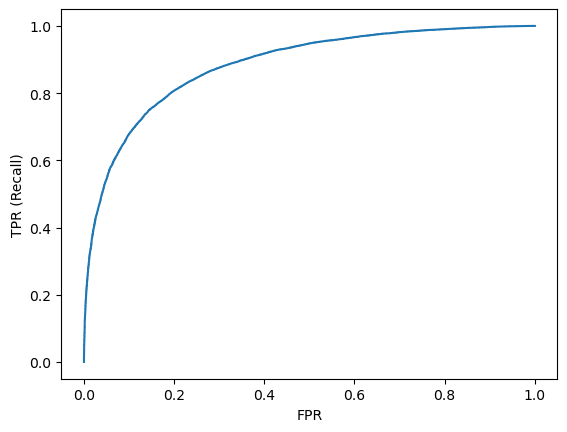

AUC: 0.8840


In [31]:
utilities.display_roc_curve(y_true=y_val, y_score=y_val_pred)

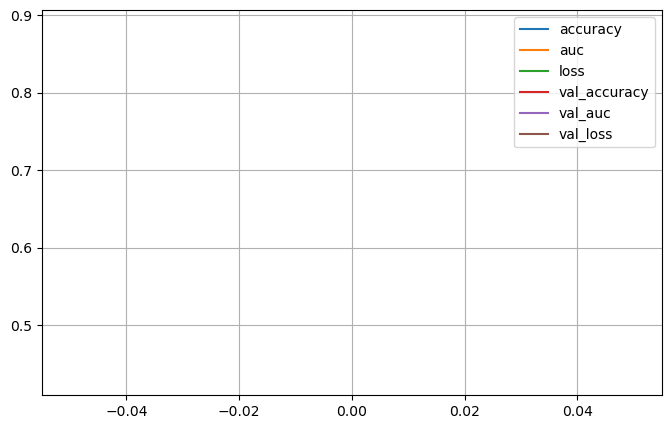

In [32]:
utilities.plot_hist_trainning(history)

In [33]:
utilities.save_model(model, history, "NN_EFPs_QG_Tagging")

In [34]:
test = keras.saving.load_model("NN_EFPs_QG_Tagging.keras")

In [35]:
test.predict(X_train[:1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


array([[0.9653694]], dtype=float32)